<a href="https://colab.research.google.com/github/Junha9/AI/blob/master/Self_Learning_ML_DL/Chapter_07_3_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# import statements
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torchvision.datasets import FashionMNIST

In [12]:
# download the data
fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

In [13]:
# scaled the data
train_input = fm_train.data
train_target = fm_train.targets
train_scaled = train_input / 255.0

In [14]:
# Split the data
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [17]:
# build a model and mount
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 10)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [18]:
# prepare the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [19]:
# Prepare the variables
train_hist = []
val_hist = []
patience = 2
best_loss =-1
early_stopping_counter = 0

In [21]:
# Now let's train the model
epochs = 20
batches = int(len(train_scaled)/32)
for epoch in range(epochs):
  model.train()
  train_loss = 0
  for i in range(batches):
    inputs = train_scaled[i*32:(i+1)*32].to(device)
    targets = train_target[i*32:(i+1)*32].to(device)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss = criterion(outputs,targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  model.eval()
  val_loss = 0
  with torch.no_grad():
    val_scaled = val_scaled.to(device)
    val_target = val_target.to(device)
    outputs = model(val_scaled)
    loss = criterion(outputs, val_target)
    val_loss = loss.item()
    train_hist.append(train_loss/batches)
    val_hist.append(val_loss)
    print(f"epoch: {epoch+1}, ",
          f"train loss: {train_loss/batches:.4f}, val loss: {val_loss:.4f}"
          )
  if best_loss == -1 or val_loss < best_loss:
    best_loss = val_loss
    early_stopping_counter = 0
    torch.save(model.state_dict(), "best_model.pt")
  else:
    early_stopping_counter += 1
  if early_stopping_counter >= patience:
    print(f"early stopped at {epoch+1}th epoch")
    break

epoch: 1,  train loss: 0.4436, val loss: 0.3939
epoch: 2,  train loss: 0.4058, val loss: 0.3661
epoch: 3,  train loss: 0.3834, val loss: 0.3577
epoch: 4,  train loss: 0.3660, val loss: 0.3466
epoch: 5,  train loss: 0.3552, val loss: 0.3455
epoch: 6,  train loss: 0.3428, val loss: 0.3368
epoch: 7,  train loss: 0.3388, val loss: 0.3316
epoch: 8,  train loss: 0.3279, val loss: 0.3355
epoch: 9,  train loss: 0.3178, val loss: 0.3334
early stopped at 9th epoch


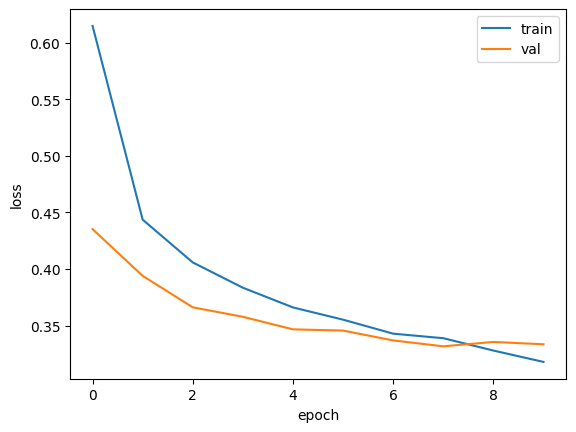

In [24]:
# Plot the result
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [25]:
# Load the saved best model
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

<All keys matched successfully>

In [27]:
# Evlauate model
model.eval()
with torch.no_grad():
  val_scaled = val_scaled.to(device)
  val_taget = val_target.to(device)
  outputs = model(val_scaled)
  predicts = torch.argmax(outputs, 1)
  corrects = (predicts == val_target).sum().item()
accuracy = corrects / len(val_target)
print(f"validation accuracy: {accuracy:.4f}")

validation accuracy: 0.8789
